In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [87]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainCopy=train.copy()
testCopy=test.copy()
train=shuffle(train)

In [88]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [89]:
train.drop(['employee_id'],axis=1,inplace=True)
test.drop(['employee_id'],axis=1,inplace=True)
train.shape,test.shape

((54808, 13), (23490, 12))

In [90]:
train.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [91]:

labels = train['recruitment_channel'].astype('category').cat.categories.tolist()
recChannelMap = {'recruitment_channel' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = train['department'].astype('category').cat.categories.tolist()
departmentMap = {'department' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = train['region'].astype('category').cat.categories.tolist()
regionMap = {'region' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [92]:
train.replace(departmentMap, inplace=True)
train.replace(regionMap, inplace=True)
train.replace(recChannelMap, inplace=True)


test.replace(departmentMap, inplace=True)
test.replace(regionMap, inplace=True)
test.replace(recChannelMap, inplace=True)

In [93]:
train['previous_year_rating']=train['previous_year_rating'].fillna(train.previous_year_rating.mode()[0])
train['education'] = train['education'].fillna(train['education'].mode()[0])

test['previous_year_rating']=test['previous_year_rating'].fillna(test.previous_year_rating.mode()[0])
test['education'] = test['education'].fillna(test['education'].mode()[0])

In [94]:
# encoding education based on data visualisation and hypothesis

education_mapper = {"Master's & above":3, "Bachelor's":2,"Below Secondary":1}
gender_mapper = {"m":1, "f":2}

In [95]:
train['education_scaled'] = train['education'].replace(education_mapper)
test['education_scaled'] = test['education'].replace(education_mapper)
train['education']=train['education_scaled']
train.drop(['education_scaled'],axis=1,inplace=True)
train['gender'] = train['gender'].replace(gender_mapper)
test['gender'] = test['gender'].replace(gender_mapper)
test['education']=test['education_scaled']
test.drop(['education_scaled'],axis=1,inplace=True)

In [96]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
396,6,16,2,2,1,1,35,3.0,6,0,0,66,0
15655,8,14,3,1,1,1,37,1.0,10,0,0,49,0
54639,9,32,3,1,1,1,39,5.0,5,1,0,78,0
30971,8,11,2,1,3,1,36,3.0,4,0,0,48,0
51934,1,20,2,1,3,1,28,3.0,5,1,0,84,0


In [97]:
train['joining_age']=train['age']-train['length_of_service']
test['joining_age']=test['age']-test['length_of_service']

train['training_hours']=train['no_of_trainings']*train['avg_training_score']
test['training_hours']=test['no_of_trainings']*test['avg_training_score']

In [98]:
train.describe()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,joining_age,training_hours
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,5.972796,16.428970,2.257627,1.297621,1.868158,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,28.938403,79.770636
std,2.506046,8.764954,0.469717,0.457216,0.980713,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,5.825101,43.879135
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,17.000000,39.000000
25%,5.000000,12.000000,2.000000,1.000000,1.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,25.000000,53.000000
50%,6.000000,15.000000,2.000000,1.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,27.000000,64.000000
75%,8.000000,22.000000,3.000000,2.000000,3.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,31.000000,84.000000
max,9.000000,34.000000,3.000000,2.000000,3.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,58.000000,710.000000


In [99]:
corr = train.corr()
corr.style.background_gradient()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,joining_age,training_hours
department,1,-0.0205925,0.0525012,0.0301084,0.00473218,0.0141517,0.0791621,-0.135561,0.0590596,-0.0882091,-0.00215111,-0.251626,0.000130116,0.0608573,-0.0968076
region,-0.0205925,1,0.00106336,-0.0197296,-0.000919649,-0.00459046,-0.0889184,-0.0059766,-0.0589394,-0.00766378,0.000307275,0.0235718,0.00884144,-0.0737752,0.00467944
education,0.0525012,0.00106336,1,0.0243486,-0.00552099,-0.0334406,0.389036,0.0268517,0.266995,0.00676087,0.0004684,0.0256455,0.0280264,0.316102,-0.0218387
gender,0.0301084,-0.0197296,0.0243486,1,-0.00656724,-0.0845012,0.0162932,0.0240241,0.0196745,0.0374003,-0.00238149,0.0244942,0.0111091,0.00702044,-0.0664722
recruitment_channel,0.00473218,-0.000919649,-0.00552099,-0.00656724,1,-0.0104051,-0.0114003,0.00573072,-0.00288686,-0.000297411,-0.00551036,-0.00241588,0.00222871,-0.012878,-0.0096758
no_of_trainings,0.0141517,-0.00459046,-0.0334406,-0.0845012,-0.0104051,1,-0.0812779,-0.0615637,-0.0572748,-0.0455757,-0.00762832,0.042517,-0.0248959,-0.0649465,0.901878
age,0.0791621,-0.0889184,0.389036,0.0162932,-0.0114003,-0.0812779,1,0.0268104,0.657111,-0.0255918,-0.00816882,-0.0483797,-0.0171659,0.833896,-0.0907978
previous_year_rating,-0.135561,-0.0059766,0.0268517,0.0240241,0.00573072,-0.0615637,0.0268104,1,0.0235044,0.337367,0.0265866,0.0719257,0.15323,0.0180467,-0.012217
length_of_service,0.0590596,-0.0589394,0.266995,0.0196745,-0.00288686,-0.0572748,0.657111,0.0235044,1,-0.0776925,-0.0399275,-0.0381222,-0.0106699,0.131927,-0.0664172
KPIs_met >80%,-0.0882091,-0.00766378,0.00676087,0.0374003,-0.000297411,-0.0455757,-0.0255918,0.337367,-0.0776925,1,0.0969998,0.078391,0.221582,0.023232,-0.00367623


The features are selected based on the data visualisation done in the other notebook named as - Datavisualisation

from there i have come to an conclusion on the number of features to be selected based on the dependency and relation observed 
in between the target variable [is_prmoted] and all the features examined

The final selected features for model training and evaluation are 

'education','department','gender','no_of_trainings','age','previous_year_rating','KPIs_met >80%','awards_won?','avg_training_score'

In [101]:
X_selected=train[['education',
  'department','gender',
  'no_of_trainings',
  'age',
  'previous_year_rating',
  'KPIs_met >80%',
  'awards_won?',
  'avg_training_score']]

In [102]:
y=train[['is_promoted']]

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [104]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_selected)

In [105]:
scaled_data_frame=pd.DataFrame(scaled_data)

In [106]:
scaled_data_frame.columns=X_selected.columns
X_selected_scaled=scaled_data_frame
X_selected_scaled.head()

,education,department,gender,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score
0,-0.548477,0.010855,1.536223,-0.415276,0.025598,-0.250651,-0.736986,-0.154018,0.195435
1,1.580483,0.808933,-0.650947,-0.415276,0.286691,-1.897069,-0.736986,-0.154018,-1.075931
2,1.580483,1.207972,-0.650947,-0.415276,0.547785,1.395766,1.356878,-0.154018,1.092871
3,-0.548477,0.808933,-0.650947,-0.415276,0.156145,-0.250651,-0.736986,-0.154018,-1.150718
4,-0.548477,-1.984338,-0.650947,-0.415276,-0.888228,-0.250651,1.356878,-0.154018,1.541588


In [107]:
class_weights_1={1:10.75,0:0.093}

In [108]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=42)

clf_1 = RandomForestClassifier(class_weight=class_weights_1)
clf_1.fit(X_train_1,y_train_1) 
# Predict on training set
pred_y_1 = clf_1.predict(X_test_1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e981973c50>)

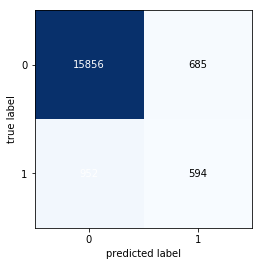

In [109]:
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test_1,pred_y_1))

In [110]:
cm1 = confusion_matrix(y_test_1,pred_y_1)
print('True positive = ', cm1[0][0])
print('False positive = ', cm1[0][1])
print('False negative = ', cm1[1][0])
print('True negative = ', cm1[1][1])

True positive =  15856
False positive =  685
False negative =  952
True negative =  594


In [111]:
from sklearn import metrics
print(metrics.f1_score(y_test_1, pred_y_1))


0.42053097345132745


In [112]:
print(metrics.roc_auc_score(y_test_1, pred_y_1))

0.6714025433528182


The above model have low f score and auc we will try to check for paremeters 

parameter tuning 

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=42)


In [114]:
import warnings
warnings.filterwarnings("ignore")

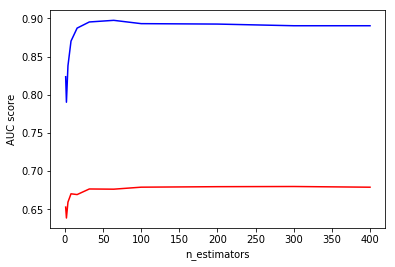

In [115]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,300,400]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(n_estimators, train_results, color="blue", label='Train AUC')
line2 = plt.plot(n_estimators, test_results, color="red", label='Test AUC')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

we can observe that after 70 trees the test performance is remaining constant thus we can choose the number of trees as 70

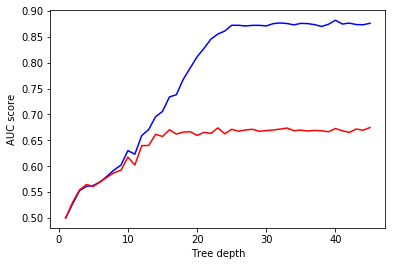

In [116]:
max_depths = np.linspace(1, 45, 45, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depths, train_results, color="blue", label="Train AUC")
line2 = plt.plot(max_depths, test_results, color="red", label="Test AUC")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

we can see that the effect of tree depth is saturated after 20 trees 

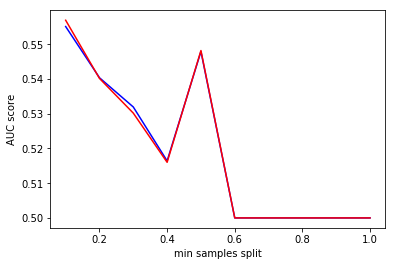

In [117]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(min_samples_splits, train_results, color="blue", label="Train AUC")
line2 = plt.plot(min_samples_splits, test_results,color="red", label="Test AUC")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()


we can see that the performace is degrading 

checking the number of features 

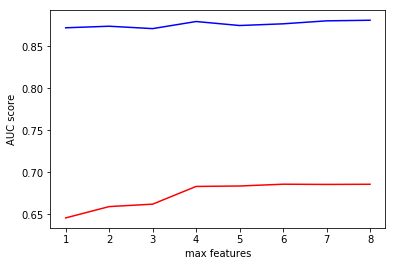

In [118]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
   roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_features, train_results, color="blue", label="Train AUC")
line2 = plt.plot(max_features, test_results,color="red", label="Test AUC")

plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()


In [43]:
n_estimators=55 
min_samples_split=0.3
max_depth=20

In [119]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=100)


In [120]:
clf2=RandomForestClassifier(n_estimators=55 ,min_samples_split=0.3,max_depth=20)

In [121]:
clf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.3,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
pred_2=clf2.predict(X_test2)

In [123]:
cm2 = confusion_matrix(y_test2,pred_2)
print('True positive = ', cm2[0][0])
print('False positive = ', cm2[0][1])
print('False negative = ', cm2[1][0])
print('True negative = ', cm2[1][1])

True positive =  16548
False positive =  13
False negative =  1439
True negative =  87


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9818fbbe0>)

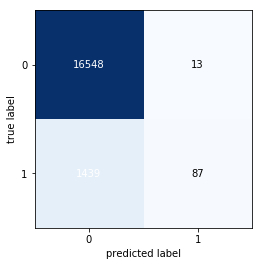

In [126]:
plot_confusion_matrix(confusion_matrix(y_test2,pred_2))

In [124]:
print(metrics.roc_auc_score(y_test2, pred_2))

0.528113409395647


In [125]:
print(metrics.f1_score(y_test2, pred_2))


0.1070110701107011


we can observe as during parameter tuning we are not mentioning the class weight the classifier is over fitting and predicting all as 0 thus f score is very less it is predicting all the '1' as '0' in most of the cases , only 87 '1' are correctly predicted

Trying with class weight 

In [127]:
clf3=RandomForestClassifier(n_estimators=55 ,min_samples_split=0.3,max_depth=20,class_weight=class_weights_1)

In [128]:
clf3.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight={1: 10.75, 0: 0.093},
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.3, min_weight_fraction_leaf=0.0,
            n_estimators=55, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [129]:
pred_3=clf3.predict(X_test2)

In [130]:
cm3 = confusion_matrix(y_test2,pred_3)
print('True positive = ', cm3[0][0])
print('False positive = ', cm3[0][1])
print('False negative = ', cm3[1][0])
print('True negative = ', cm3[1][1])

True positive =  9
False positive =  16552
False negative =  0
True negative =  1526


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e98064b3c8>)

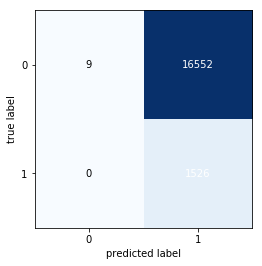

In [131]:
plot_confusion_matrix(confusion_matrix(y_test2,pred_3))

this time the classifier is over fittin gon the class '1' thus all are predicted as '1' even if thet are '0'
which is not good for our scenario as we want people who actuallly deserve to be promoted

# XGBOOST with scale parameter

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=1000)


In [133]:
from xgboost import XGBClassifier
auc=[]
f1=[]
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf_xgb = XGBClassifier(scale_pos_weight=i)
    clf_xgb.fit(X_train, y_train)
    predict = clf_xgb.predict(X_test)
    auc.append(metrics.roc_auc_score(y_test, predict))
    f1.append(metrics.f1_score(y_test, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test, predict))
    print(" the f1 score is ",metrics.f1_score(y_test, predict))

scale_pos_weight = 1: 
 the auc value is  0.6357892057666946
 the f1 score is  0.42352941176470593
scale_pos_weight = 2: 
 the auc value is  0.6473805487827304
 the f1 score is  0.441747572815534
scale_pos_weight = 3: 
 the auc value is  0.6618090875928623
 the f1 score is  0.45576407506702415
scale_pos_weight = 4: 
 the auc value is  0.6801661523954889
 the f1 score is  0.4553158705701078
scale_pos_weight = 5: 
 the auc value is  0.7185727275086702
 the f1 score is  0.42321000798509445
scale_pos_weight = 6: 
 the auc value is  0.7571768017019275
 the f1 score is  0.39519566059666794
scale_pos_weight = 7: 
 the auc value is  0.7753110306987968
 the f1 score is  0.3888310787374263
scale_pos_weight = 8: 
 the auc value is  0.8054334319627909
 the f1 score is  0.3653556255995615
scale_pos_weight = 9: 
 the auc value is  0.8087104279355055
 the f1 score is  0.35558986234401135
scale_pos_weight = 10: 
 the auc value is  0.8069383100686595
 the f1 score is  0.3461254612546126
scale_pos_weigh

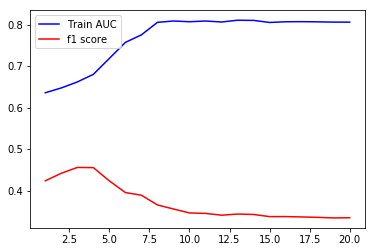

In [134]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(scale_pos_weight, auc, color="blue", label="Train AUC")
line2 = plt.plot(scale_pos_weight, f1,color="red", label="f1 score")
plt.legend(loc='upper left')

choosing scale_pos_weight = 4  as the metric for our evaluation is f1 score  

In [135]:
clf_xgb_1 = XGBClassifier(scale_pos_weight=4)
clf_xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
       silent=True, subsample=1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e980df3390>)

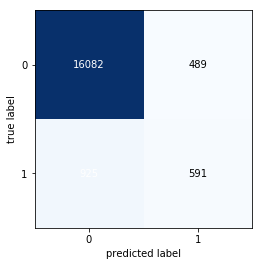

In [136]:
pred_4=clf_xgb_1.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test,pred_4))

In [77]:
scaler = StandardScaler()
cols=list(X_train.columns)
test_selected=test[cols]
scaled_test = scaler.fit_transform(test_selected)
test_scaled=pd.DataFrame(scaled_test)
test_scaled.columns=cols 
pred_test_1=clf_xgb_1.predict(test_scaled)
# for submissions                          
ids=testCopy['employee_id']
submission = pd.DataFrame({'employee_id': ids,
                           'is_promoted':pred_test_1
                           })

submission.to_csv("xgb_with_scale_pos_weight_4.csv")

we need to make the model more generic thus trying lightGBM with scale_pos_weight 

In [137]:
import lightgbm as lgb 

In [138]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=333)


In [139]:
from lightgbm import LGBMClassifier
auc=[]
f1=[]
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf_lgb = LGBMClassifier(scale_pos_weight=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

scale_pos_weight = 1: 
 the auc value is  0.6653002841662924
 the f1 score is  0.49029126213592233
scale_pos_weight = 2: 
 the auc value is  0.6698751705176775
 the f1 score is  0.4926990108337258
scale_pos_weight = 3: 
 the auc value is  0.6845793141419972
 the f1 score is  0.49428692340245456
scale_pos_weight = 4: 
 the auc value is  0.7124231551568643
 the f1 score is  0.4904214559386973
scale_pos_weight = 5: 
 the auc value is  0.7431588248094718
 the f1 score is  0.4471606824548001
scale_pos_weight = 6: 
 the auc value is  0.7769351891597501
 the f1 score is  0.4290361935746238
scale_pos_weight = 7: 
 the auc value is  0.7935980632294866
 the f1 score is  0.4083842794759825
scale_pos_weight = 8: 
 the auc value is  0.7968821670633642
 the f1 score is  0.39073482428115014
scale_pos_weight = 9: 
 the auc value is  0.8056976077598124
 the f1 score is  0.3878732480195003
scale_pos_weight = 10: 
 the auc value is  0.8096596051429206
 the f1 score is  0.3818978102189781
scale_pos_weight

Text(0, 0.5, 'scores ')

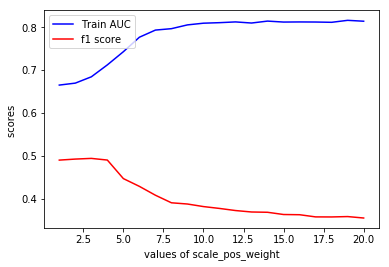

In [142]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(scale_pos_weight, auc, color="blue", label="Train AUC")
line2 = plt.plot(scale_pos_weight, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of scale_pos_weight')
plt.ylabel("scores ")

choosing 2 as scale_pos_weight for lgmboost , we can also observe that the f1 score is increased as compared to the XGboost which maxed out at 0.45 while for lgb we are getting maxed f1 score at 0.4942 at scale pos value of 3.

In [143]:
clf_lgb_1 = LGBMClassifier(scale_pos_weight=3)
clf_lgb_1.fit(X_train_lgbm, y_train_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=3, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [145]:
predict_lgbm1=clf_lgb_1.predict(X_test_lgbm)
cm4 = confusion_matrix(y_test_lgbm, predict_lgbm1)
print('True positive = ', cm4[0][0])
print('False positive = ', cm4[0][1])
print('False negative = ', cm4[1][0])
print('True negative = ', cm4[1][1])

True positive =  16308
False positive =  262
False negative =  933
True negative =  584


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e995ff8668>)

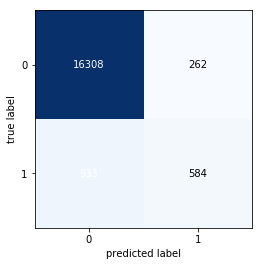

In [152]:
plot_confusion_matrix(confusion_matrix(y_test_lgbm, predict_lgbm1))

In [155]:
scaler = StandardScaler()
cols=list(X_train.columns)
test_selected=test[cols]
scaled_test = scaler.fit_transform(test_selected)
test_scaled=pd.DataFrame(scaled_test)
test_scaled.columns=cols 
pred_test_2=clf_lgb_1.predict(test_scaled)
# for submissions                          
ids=testCopy['employee_id']
submission = pd.DataFrame({'employee_id': ids,
                           'is_promoted':pred_test_2
                           })

submission.to_csv("lgb_with_scale_pos_weight_3.csv")

we can see that the contest requires less false positives ie not to predict someone as promoted when he/ she is not eligible
